# Imports


In [35]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_connectivity
from tqdm.notebook import tqdm
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

import acareeg
from infant_connectivity import get_ind_both_time_point, logit, add_bin_dist

# Global variables and configuration

In [36]:
palette = sns.color_palette(["green", "orange", "red"])
con_path = Path("/Users/christian/Documents/con_paper/")

plt.rcParams['figure.facecolor'] = 'white'

# Loading data

In [37]:
band = "broadband"
dat = pd.read_csv("analysis_data.csv")  # From notebok 2.1

### Regression with ADOS scores

In [38]:
# 'adoscss_24m', 'ados_sacss_24m', 'ados_rrbcss_24m'
def plot_ados_reg(suffix="_earliest"):

    ados_str_map = {f'adoscss{suffix}': "Overall", 
                    f'ados_sacss{suffix}': "Social affect", 
                    f'ados_rrbcss{suffix}': "RRBs"}    
    
    for ados_str in ados_str_map:
        print("")
        print(f"======================== {ados_str} =========================")

        tmp = dat.groupby(["site", "age", "group", "subject", "sex"], observed=True).mean().reset_index()
        formula = f"log_con ~ {ados_str}*sex + site*age"
        md = smf.ols(formula, tmp[tmp.group != "Control"])
        print(md.fit().pvalues, md.fit().params)

        sex_site_means = tmp.groupby(["site", "sex"], observed=True).mean()
        sex_means = sex_site_means.groupby("sex").mean()
        mean_log_con = tmp[tmp.group == "Control"].groupby(["site", "sex"], observed=True).mean()["log_con"]

        tmp2 = tmp.copy()
        for site in ["London", "Seattle"]:
            for sex in ["F", "M"]:
                inds = (tmp.sex == sex) & (tmp.site == site) & (tmp.group != "Control")
                tmp2.loc[inds, "log_con"] -= sex_site_means.loc[(site, sex)]["log_con"]
                tmp2.loc[inds, "log_con"] += sex_means.loc[sex]["log_con"]    

        plt.rcParams['figure.facecolor'] = 'white'

        tmp = dat[~dat.outliers_logit]
        tmp["log_con"] = logit(tmp.con)
        tmp = tmp.groupby(["site", "age", "group", "risk", "subject_no", "sex"], observed=True).mean()[["log_con", ados_str]].reset_index()
        mean_log_con = tmp[tmp.group == "Control"].groupby(["site", 'age', "sex"], observed=True).mean()["log_con"]

        #pd.set_option('display.max_rows', None)
        #print(tmp[tmp.risk == "HRA"])
        dep_var = ados_str
        fig, axes = plt.subplots(2, 2, figsize=(5, 4.5), sharex=True, sharey=True)
        for ax_row, sex in zip(axes, ["F", "M"]):
            for age, ax in zip([6, 12], ax_row):
                for site, color, x in zip(["London", "Seattle"], ["b", "r"], [1, 7]):       
                    inds = ((tmp.age == age) & (tmp.sex == sex) & (tmp.site == site) 
                            & ~np.isnan(tmp[dep_var])  & (tmp.risk == "HRA"))
                    ax.set_xlim(0.5, 10.5)

                    print(site, age, sex, np.sum(inds))

                    sns.regplot(data=tmp[inds], x=dep_var, y="log_con", ax=ax, #ci=None,
                                color=color, truncate=False, scatter=False, label=site)
                    ax.scatter(tmp[inds & (tmp.group == "HRA-ASD")][ados_str], 
                                tmp[inds & (tmp.group == "HRA-ASD")].log_con, s=30, 
                               color=color, marker="*")                        
                    ax.scatter(tmp[inds & (tmp.group == "HRA-noASD")][ados_str], 
                                tmp[inds & (tmp.group == "HRA-noASD")].log_con, s=15, 
                               color=color, marker=".")                   
                    N1 = len(tmp[inds & (tmp.group == "HRA-noASD")][ados_str])
                    N2 = len(tmp[inds & (tmp.group == "HRA-ASD")][ados_str])


                    ax.axhline(y=mean_log_con.loc[site, age, sex], color=color, linestyle="dashed")    

                    rho, p = pearsonr(tmp[dep_var][inds], tmp["log_con"][inds])
                    huber_t = smf.rlm("log_con ~ " + dep_var, data=tmp[inds], 
                                      M=sm.robust.norms.HuberT())
                    hub_results = huber_t.fit()
                    p = hub_results.pvalues[1]
                    ax.text(x, -1.4, "r={:.2f}\np={:.3f}\nN={}({})".format(rho, p, N1+N2, N2), color=color)

                inds = (tmp.age == age) & (tmp.sex == sex) & (tmp.group != "Control") & ~np.isnan(tmp[dep_var])   
                rho, p = pearsonr(tmp[dep_var][inds], tmp["log_con"][inds])
                N1 = len(tmp[inds & (tmp.group == "HRA-noASD")][ados_str])
                N2 = len(tmp[inds & (tmp.group == "HRA-ASD")][ados_str])
                huber_t = smf.rlm("log_con ~ " + dep_var, data=tmp[inds], 
                                  M=sm.robust.norms.HuberT())
                hub_results = huber_t.fit()
                p = hub_results.pvalues[1]        
                ax.text(x, -1.9, "r={:.2f}\np={:.3f}".format(rho, p), color="k")
                #abline(hub_results.params[1], hub_results.params[0], ax, color="k", label="pooled")
                #sns.regplot(data=tmp[inds], x=dep_var, y="log_con", ax=ax, ci=None,
                #            color="k", truncate=False, scatter=False, label="Pooled")        


        axes[0, 0].set_ylabel("logit(CIPLV) - Female")        
        axes[1, 0].set_ylabel("logit(CIPLV) - Male")        
        for ax in axes[0, :]:
            ax.set_xlabel("")
        for ax in axes[:, 1:].ravel():
            ax.set_ylabel("")        


        axes[0, 0].set_title("6 months")       
        axes[0, 1].set_title("12 months")          

        axes[1, 1].set_xlabel(f"ADOS severity scores\n({ados_str_map[ados_str]})")   
        axes[1, 0].set_xlabel(f"ADOS severity scores\n({ados_str_map[ados_str]})")       

        axes[1, 0].legend(loc="lower left")

        axes[0, 0].set_ylim(-1.92, -1.21)
        plt.subplots_adjust(wspace=0.001, hspace=0.001, left=0.15,
                            bottom=0.15, right=0.99, top=0.95)
        fig.savefig("images/" + f"sex_{ados_str}_regressions.png", dpi=300)    



======================== adoscss_earliest =========================
Intercept                    2.770449e-68
sex[T.M]                     2.425269e-01
site[T.Seattle]              1.593370e-01
adoscss_earliest             1.922660e-01
adoscss_earliest:sex[T.M]    2.123133e-01
age                          1.568951e-04
site[T.Seattle]:age          7.022710e-01
dtype: float64 Intercept                   -1.511069
sex[T.M]                    -0.031994
site[T.Seattle]              0.075275
adoscss_earliest            -0.006306
adoscss_earliest:sex[T.M]    0.008130
age                         -0.011613
site[T.Seattle]:age         -0.002070
dtype: float64
London 6 F 18
Seattle 6 F 6
London 12 F 27
Seattle 12 F 6
London 6 M 15
Seattle 6 M 10
London 12 M 19
Seattle 12 M 11

======================== ados_sacss_earliest =========================
Intercept                       4.596589e-66
sex[T.M]                        1.931715e-01
site[T.Seattle]                 1.497968e-01
ados_sacss_earli

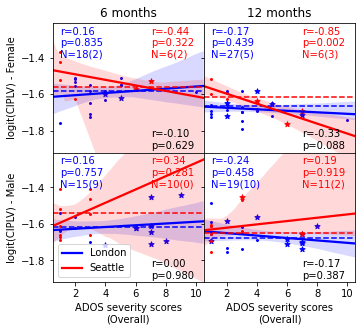

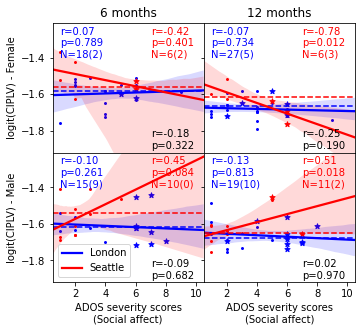

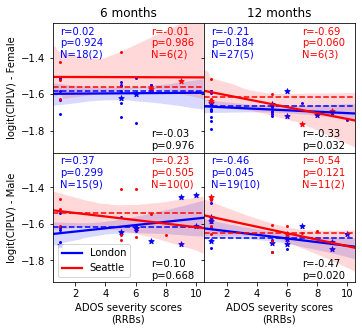

In [39]:
plot_ados_reg(suffix="_earliest")

### Confirmation that the choice of ADOS evaluation time points does not change significantly our results


======================== adoscss_latest =========================
Intercept                  2.260710e-71
sex[T.M]                   6.841854e-01
site[T.Seattle]            1.916543e-01
adoscss_latest             3.523117e-01
adoscss_latest:sex[T.M]    6.519523e-01
age                        2.148474e-04
site[T.Seattle]:age        6.860283e-01
dtype: float64 Intercept                 -1.520025
sex[T.M]                  -0.010814
site[T.Seattle]            0.069781
adoscss_latest            -0.003952
adoscss_latest:sex[T.M]    0.002557
age                       -0.011372
site[T.Seattle]:age       -0.002190
dtype: float64
London 6 F 18
Seattle 6 F 6
London 12 F 27
Seattle 12 F 6
London 6 M 15
Seattle 6 M 10
London 12 M 19
Seattle 12 M 11

======================== ados_sacss_latest =========================
Intercept                     4.415367e-68
sex[T.M]                      3.473350e-01
site[T.Seattle]               1.823496e-01
ados_sacss_latest             2.701887e-01
ados_sacss_

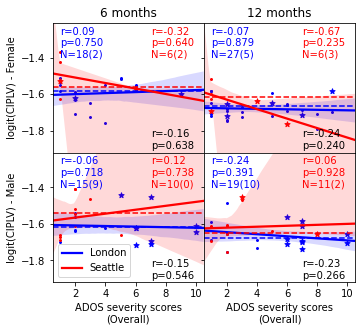

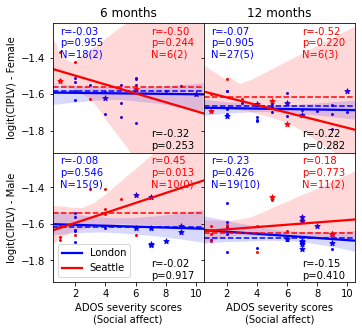

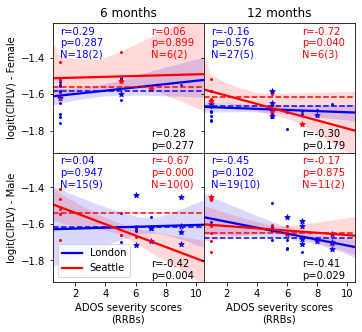

In [40]:
plot_ados_reg(suffix="_latest")

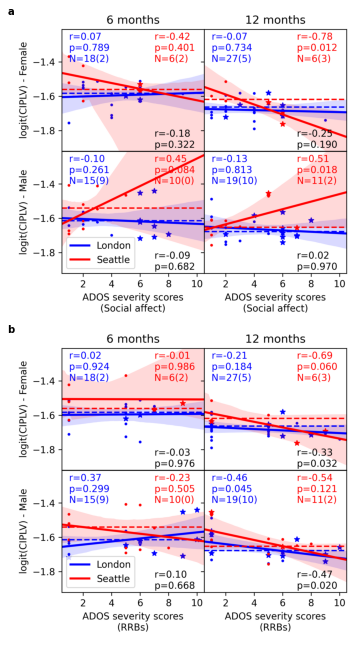

In [41]:
img_file_names = ["sex_ados_sacss_earliest_regressions.png", "sex_ados_rrbcss_earliest_regressions.png"]

fig, axes = plt.subplots(2, 1, figsize=(5, 9))
for ax, file_name in zip(axes, img_file_names):
    img = plt.imread("images/" + file_name)
    ax.imshow(img)
    ax.axis(False)

fig.text(0.02, 0.98, "a", fontweight="bold")    
fig.text(0.02, 0.49, "b", fontweight="bold")        
    
fig.tight_layout()
fig.savefig("images/" + "sex_ados_sacss_rbbcss_earliest_regressions.png", dpi=300)


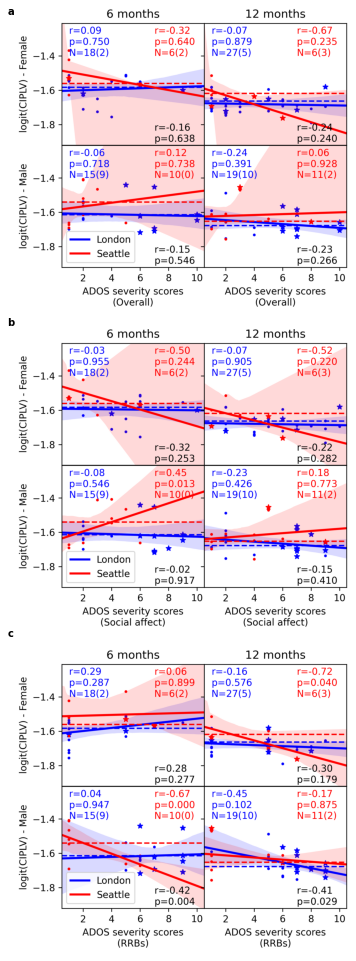

In [42]:
img_file_names = ["sex_adoscss_latest_regressions.png", "sex_ados_sacss_latest_regressions.png", "sex_ados_rrbcss_latest_regressions.png"]

fig, axes = plt.subplots(3, 1, figsize=(5, 13.5))
for ax, file_name in zip(axes, img_file_names):
    img = plt.imread("images/" + file_name)
    ax.imshow(img)
    ax.axis(False)

fig.text(0.02, 0.98, "a", fontweight="bold")    
fig.text(0.02, 0.66, "b", fontweight="bold")        
fig.text(0.02, 0.34, "c", fontweight="bold")        
    
fig.tight_layout()
fig.savefig("images/" + "sex_ados_all_latest_regressions.png", dpi=300)

# Supplementary analysis to detect localized effects

In [44]:
from scipy.stats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power

tmp = pd.concat([dat, dat.rename(columns={"region1" : "region2", "region2": "region1"})])

tmp["log_con"] = logit(tmp.con)
tmp = tmp.groupby(["region1", "subject", "site", "age", "group"], observed=True).mean().reset_index()

ados_strs = ['ados_sacss_earliest', 'ados_rrbcss_earliest']

groupby = tmp.groupby(["region1", "site", "age"], observed=True)
vars = {}
for dep_var in ados_strs:
    vars[dep_var] = {}
    
    for var in ["r", "p", "n"]:
        vars[dep_var][var] = []
    for (region, site, age), group in groupby:
        group = group.dropna()
        rho, p = pearsonr(group[group.region1 == region][dep_var], 
                        group[group.region1 == region]["log_con"])
        huber_t = smf.rlm("log_con ~ " + dep_var, data=group[group.region1 == region], 
                            M=sm.robust.norms.HuberT())
        hub_results = huber_t.fit()
        p = hub_results.pvalues[1]

        vars[dep_var]["r"].append(rho)
        vars[dep_var]["p"].append(p)
        vars[dep_var]["n"].append(len(group[group.region1 == region][dep_var]))

In [45]:
tmp2 = groupby.mean()
tmp3 = groupby.mean()

for var in ["r", "p", "n"]:
    tmp2[var] =  vars["ados_sacss_earliest"][var]
    tmp3[var] =  vars['ados_rrbcss_earliest'][var]
    
tmp2["dep_var"] = "ados_sacss_earliest"
tmp3["dep_var"] = "ados_rrbcss_earliest"

tmp2 = pd.concat([tmp2, tmp3]).reset_index()


In [46]:
def get_high_correl(df, threshold):
    if threshold > 0:
        x = df.groupby(["region1", "age"]).min()["r"].sort_values()
    else:
        x = df.groupby(["region1", "age"]).max()["r"].sort_values()

    tmp3 = df.pivot_table(index=["region1", "age"], columns="site", 
                            values=["r", "p", "n"])
    if threshold > 0:                            
        tmp3 = tmp3.loc[x[x > threshold].index]
    else:
        tmp3 = tmp3.loc[x[x < threshold].index]

    tmp3 = tmp3.reorder_levels([1, 0], axis=1).sort_index(axis=1).reset_index()
    tmp3.columns.names = ["", ""]
    tmp3[("", "corrected_p")] = tmp3["Seattle", "p"]*tmp3["London", "p"]*len(tmp2.reset_index().age.unique())*len(tmp2.reset_index().region1.unique())
    tmp3.columns = pd.MultiIndex.from_tuples([("", "region"), ("", "age")] + list(tmp3.columns)[2:])
    return tmp3


In [47]:
len(dat.region2.unique())

64

In [48]:
get_high_correl(tmp2[tmp2.dep_var == "ados_sacss_earliest"], threshold=0.2)

London                     Seattle            \
                    region age      n         p         r       n         p   
0         parsorbitalis-lh   6     32  0.299910  0.200516      31  0.027840   
1        middletemporal-lh   6     32  0.093861  0.322919      31  0.133322   
2  lateralorbitofrontal-lh   6     32  0.070910  0.311241      31  0.023610   

                         
          r corrected_p  
0  0.370988    1.085417  
1  0.200675    1.626796  
2  0.278173    0.217649

In [49]:
get_high_correl(tmp2[tmp2.dep_var == "ados_sacss_earliest"], threshold=-0.2)

Empty DataFrame
Columns: [(, region), (, age), (London, n), (London, p), (London, r), (Seattle, n), (Seattle, p), (Seattle, r), (, corrected_p)]
Index: []

In [50]:
get_high_correl(tmp2[tmp2.dep_var == "ados_rrbcss_earliest"], threshold=0.2)

London                     Seattle            \
                    region age      n         p         r       n         p   
0         parsorbitalis-lh   6     32  0.193389  0.264092      31  0.442656   
1   medialorbitofrontal-lh   6     32  0.219666  0.232055      31  0.045005   
2  lateralorbitofrontal-lh   6     32  0.130945  0.293945      31  0.098035   
3   caudalmiddlefrontal-lh   6     32  0.104195  0.358343      31  0.133915   
4         supramarginal-lh   6     32  0.081560  0.329236      31  0.234206   

                         
          r corrected_p  
0  0.223226   11.128593  
1  0.306466    1.285193  
2  0.255105    1.668833  
3  0.258061    1.813930  
4  0.301286    2.483242

In [51]:
get_high_correl(tmp2[tmp2.dep_var == "ados_rrbcss_earliest"], threshold=-0.2)

London                     Seattle            \
                    region age      n         p         r       n         p   
0   caudalmiddlefrontal-lh  12     45  0.012407 -0.336530      29  0.035774   
1  lateralorbitofrontal-rh  12     45  0.021266 -0.390817      29  0.119168   
2         parsorbitalis-lh  12     45  0.147103 -0.235903      29  0.183860   

                         
          r corrected_p  
0 -0.393223    0.057703  
1 -0.268392    0.329448  
2 -0.241525    3.516032